# S&P500 Trend Model

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import os

%matplotlib inline

In [2]:
from dotenv import load_dotenv
load_dotenv()
FRED_KEY = os.getenv("FRED_KEY")

In [3]:
from urllib.request import urlopen
import json

def get_jsonparsed_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

# Data Cleaning

In [4]:
# Pulling time series:
def pull_time_series(time_series_code, dataframe_name):

    url = (f"https://api.stlouisfed.org/fred/series/observations?series_id={time_series_code}&api_key={FRED_KEY}&file_type=json")
    raw_data = get_jsonparsed_data(url)
    dataframe_name = pd.DataFrame(raw_data['observations'])
    
    # convert to datetime
    dataframe_name['Date'] = pd.to_datetime(dataframe_name['date'])
    dataframe_name.set_index('Date', inplace=True)
    dataframe_name = dataframe_name.drop(columns=["date", "realtime_start", "realtime_end"]).sort_index()
    dataframe_name['value'] = pd.to_numeric(dataframe_name['value'],errors='coerce')
    return dataframe_name

In [5]:
# Setting up universal data cleaning functions for FRED data
def clean_data(df,variable_name):
    df.rename(columns={"value":variable_name},inplace=True)
    return df

def pct_change(df,value, time_period):
    df[f'{value}_YoY'] = df[value].pct_change(time_period) * 100
    df[f'{value}_YoY'] = df[f'{value}_YoY'].replace(-np.inf, np.nan).dropna()
    return df

def set_date_to_month_end(df):
    df.index = df.index.to_period('M').to_timestamp('M')
    return df

def resample_monthly(df, variable_name):
    df_resampled = df[variable_name].resample('M').sum()
    df_resampled = pd.DataFrame(df_resampled)
    return df_resampled

In [6]:
# Pull Raw data for model
US_GDP_data = pull_time_series("A191RL1Q225SBEA", "US_GDP_Growth")

US_GDP_df = pull_time_series("GDPC1", "REAL_GDP")
US_Real_PCE_data = pull_time_series("PCEC96", "US_Real_PCE")
US_Initial_Claims_data = pull_time_series("ICSA", "US_Initial_Claims")
US_Cap_Util = pull_time_series("TCU", "US_Capital_Utilization")

US_Real_Disposable_Income = pull_time_series("DSPIC96", "Real_Disposable_Personal_Income")
US_Personal_Savings_Rate = pull_time_series("PSAVERT", "US_Personal_Savings_Rate_%_of_DPI")
US_M2_stock = pull_time_series("M2", "M2_Money_Stock")
US_PCE_data = pull_time_series("PCETRIM12M159SFRBDAL", "PCE Inflation Rate")
US_yield_curve = pull_time_series("T10Y2Y", "US 10 Minus 2 Yr Yield")

### Macro Indicators Processing Section

In [7]:
# Clean PCE data: feature (1 of 8)
clean_data(US_Real_PCE_data, "Real_PCE")
pct_change(US_Real_PCE_data, "Real_PCE", 12)

# Changing date index to last day of the month
US_Real_PCE_data = set_date_to_month_end(US_Real_PCE_data)

# Drop Na's
US_Real_PCE_data = US_Real_PCE_data.dropna()
US_Real_PCE_data.head()

Real_PCE  Real_PCE_YoY
Date                              
2003-01-31    9219.1      2.643152
2003-02-28    9186.3      1.821104
2003-03-31    9241.2      2.445514
2003-04-30    9287.2      2.436496
2003-05-31    9308.5      3.063620

In [8]:
# Clean US Initial Claims data: feature (2 of 8)
clean_data(US_Initial_Claims_data, "Initial_Claims")

# Resample Weekly data to Monthly
US_Initial_Claims_data_resampled = resample_monthly(US_Initial_Claims_data, "Initial_Claims")

# Calculate YoY change
pct_change(US_Initial_Claims_data_resampled, "Initial_Claims", 12)
US_Initial_Claims_data_resampled.tail()

Initial_Claims  Initial_Claims_YoY
Date                                          
2020-05-31        12329000         1312.256586
2020-06-30         5996000          442.624434
2020-07-31         5475000          540.350877
2020-08-31         5161000          377.428307
2020-09-30         2629000          208.568075

In [9]:
# Clean capacity utilization data: feature (3 of 8)
clean_data(US_Cap_Util, "Capacity_Utilization")

# Calculate YoY Change
pct_change(US_Cap_Util, "Capacity_Utilization", 12)

# Changing date index to last day of the month
US_Cap_Util = set_date_to_month_end(US_Cap_Util)

US_Cap_Util.tail()

Capacity_Utilization  Capacity_Utilization_YoY
Date                                                      
2020-04-30               64.0552                -17.629041
2020-05-31               64.6990                -16.834414
2020-06-30               68.6926                -11.586505
2020-07-31               71.1399                 -8.116476
2020-08-31               71.4197                 -8.244065

In [10]:
# Clean US_Personal_Savings_Rate data: feature (4 of 8)

clean_data(US_Personal_Savings_Rate, "US_Personal_Savings_Rate_%_of_DPI")

# Calculate YoY Change
pct_change(US_Personal_Savings_Rate, "US_Personal_Savings_Rate_%_of_DPI", 12)

# Changing date index to last day of the month
US_Personal_Savings_Rate_df = set_date_to_month_end(US_Personal_Savings_Rate)

US_Personal_Savings_Rate_df.tail(20)

US_Personal_Savings_Rate_%_of_DPI  \
Date                                            
2018-12-31                                9.1   
2019-01-31                                8.5   
2019-02-28                                8.6   
2019-03-31                                8.0   
2019-04-30                                7.5   
2019-05-31                                7.3   
2019-06-30                                7.1   
2019-07-31                                7.0   
2019-08-31                                7.3   
2019-09-30                                7.3   
2019-10-31                                7.2   
2019-11-30                                7.5   
2019-12-31                                7.2   
2020-01-31                                7.6   
2020-02-29                                8.3   
2020-03-31                               12.9   
2020-04-30                               33.7   
2020-05-31                               24.6   
2020-06-30                               19.2   
2020-07-31                               17.8   

            US_Personal_Savings_Rate_%_of_DPI_YoY  
Date                                               
2018-12-31                              37.878788  
2019-01-31                              13.333333  
2019-02-28                              10.256410  
2019-03-31                               2.564103  
2019-04-30                              -2.597403  
2019-05-31                              -5.194805  
2019-06-30                             -10.126582  
2019-07-31                             -11.392405  
2019-08-31                              -6.410256  
2019-09-30                              -7.594937  
2019-10-31                              -5.263158  
2019-11-30                               1.351351  
2019-12-31                             -20.879121  
2020-01-31                             -10.588235  
2020-02-29                              -3.488372  
2020-03-31                              61.250000  
2020-04-30                             349.333333  
2020-05-31                             236.986301  
2020-06-30                             170.422535  
2020-07-31                             154.285714

In [11]:
# Clean US_Real_Disposable_Income data: feature (5 of 8)

clean_data(US_Real_Disposable_Income, "US_Real_DPI")

# Calculate YoY Change
pct_change(US_Real_Disposable_Income, "US_Real_DPI", 12)

# Changing date index to last day of the month
US_Real_Disposable_Income_df = set_date_to_month_end(US_Real_Disposable_Income)

US_Real_Disposable_Income_df.tail()

US_Real_DPI  US_Real_DPI_YoY
Date                                    
2020-03-31      14949.3         0.630061
2020-04-30      17254.7        16.450476
2020-05-31      16400.8        10.744382
2020-06-30      16107.2         8.635714
2020-07-31      16091.6         8.431770

In [12]:
# Clean M2 Money stock data: feature (6 of 8)
clean_data(US_M2_stock, "M2")

# Resample Weekly data to Monthly (not using resampling function here as we don't want to sum weekly figures, we just want the last figure)
M2_stock_resampled = US_M2_stock.resample('M').last()

# Calculate YoY change
pct_change(M2_stock_resampled, "M2", 12)

M2_stock_resampled.tail(13)

M2     M2_YoY
Date                          
2019-09-30  15086.4   5.975077
2019-10-31  15189.1   6.605138
2019-11-30  15282.4   7.193760
2019-12-31  15333.6   6.388027
2020-01-31  15445.3   6.724663
2020-02-29  15434.1   6.653169
2020-03-31  16533.3  13.860213
2020-04-30  17406.5  19.313314
2020-05-31  17938.6  22.058693
2020-06-30  18233.5  23.215142
2020-07-31  18284.5  22.685123
2020-08-31  18464.7  23.607262
2020-09-30  18700.6  23.956676

In [13]:
# Clean PCE data: feature (7 of 8)
clean_data(US_PCE_data, "Inflation Rate")

# Changing date index to last day of the month
US_PCE_data = set_date_to_month_end(US_PCE_data)
US_PCE_data.isnull().sum()

Inflation Rate    0
dtype: int64

In [14]:
# Clean Yield Curve data: feature (8 of 8)
clean_data(US_yield_curve, "10yr minus 2yr yield")

# Construct the dependent variable where if monthly return is greater than 0, then 1, else, 0.
US_yield_curve['Inversion Signal'] = np.where(US_yield_curve['10yr minus 2yr yield'] < 0, 1.0, 0.0)

# CLean Yield Curve data 
US_yield_curve = US_yield_curve.resample('M').agg({'10yr minus 2yr yield':'last', 'Inversion Signal':np.any})

US_yield_curve.tail(20)

10yr minus 2yr yield  Inversion Signal
Date                                              
2019-02-28                  0.21             False
2019-03-31                  0.14             False
2019-04-30                  0.24             False
2019-05-31                  0.19             False
2019-06-30                  0.25             False
2019-07-31                  0.13             False
2019-08-31                  0.00              True
2019-09-30                  0.05             False
2019-10-31                  0.17             False
2019-11-30                  0.17             False
2019-12-31                  0.34             False
2020-01-31                  0.18             False
2020-02-29                  0.27             False
2020-03-31                  0.47             False
2020-04-30                  0.44             False
2020-05-31                  0.49             False
2020-06-30                  0.50             False
2020-07-31                  0.44             False
2020-08-31                  0.58             False
2020-09-30                  0.54             False

In [15]:
# Final US yield curve data
US_yield_curve["Inversion Signal"] = US_yield_curve["Inversion Signal"].astype(int)

In [16]:
US_yield_curve.tail(20)

10yr minus 2yr yield  Inversion Signal
Date                                              
2019-02-28                  0.21                 0
2019-03-31                  0.14                 0
2019-04-30                  0.24                 0
2019-05-31                  0.19                 0
2019-06-30                  0.25                 0
2019-07-31                  0.13                 0
2019-08-31                  0.00                 1
2019-09-30                  0.05                 0
2019-10-31                  0.17                 0
2019-11-30                  0.17                 0
2019-12-31                  0.34                 0
2020-01-31                  0.18                 0
2020-02-29                  0.27                 0
2020-03-31                  0.47                 0
2020-04-30                  0.44                 0
2020-05-31                  0.49                 0
2020-06-30                  0.50                 0
2020-07-31                  0.44                 0
2020-08-31                  0.58                 0
2020-09-30                  0.54                 0

In [17]:
#Download stock data
def download_data(tickers, start_date):
    stock_data = yf.download(tickers,start=start_date)
    stock_data = stock_data.drop(columns=["Close", "High", "Low", "Open", "Volume"])
    stock_data["Adj Close"] = stock_data['Adj Close'].astype(float)
    stock_data = stock_data.dropna()
    return stock_data

In [18]:
# Download VVIX data
VVIX_df = download_data(['^VIX'], "1980-01-01")
VVIX_df.head()

[*********************100%***********************]  1 of 1 completed


Adj Close
Date                 
1990-01-02  17.240000
1990-01-03  18.190001
1990-01-04  19.219999
1990-01-05  20.110001
1990-01-08  20.260000

In [19]:
# Download FEDEX
industrials_df = download_data(['FDX'], "1980-01-01")
industrials_df.head()

[*********************100%***********************]  1 of 1 completed


Adj Close
Date                 
1980-01-02   2.484676
1980-01-03   2.539890
1980-01-04   2.691732
1980-01-07   2.719339
1980-01-08   2.815966

In [20]:
# Clean FDX data and calculate monthly returns
FDX_resampled = industrials_df.resample('M').last()
FDX_resampled["FDX Monthly Return"] = FDX_resampled['Adj Close'].pct_change() * 100
FDX_resampled = FDX_resampled.dropna()
FDX_resampled.tail()

Adj Close  FDX Monthly Return
Date                                      
2020-05-31  129.565933            2.989675
2020-06-30  139.820084            7.914233
2020-07-31  167.919708           20.096987
2020-08-31  219.213013           30.546328
2020-09-30  250.169998           14.121874

In [21]:
# Download USD returns
USD_df = download_data(['DX-Y.NYB'], "1980-01-01")
USD_df.head()

[*********************100%***********************]  1 of 1 completed


Adj Close
Date                 
1980-01-02  85.320000
1980-01-03  85.260002
1980-01-04  85.230003
1980-01-07  84.790001
1980-01-08  85.070000

In [22]:
# Clean USD data and calculate monthly returns
USD_resampled = USD_df.resample('M').last()
USD_resampled["USD Monthly Return"] = USD_resampled['Adj Close'].pct_change() * 100
USD_resampled = USD_resampled.dropna()
USD_resampled.tail()

Adj Close  USD Monthly Return
Date                                     
2020-05-31  98.339996           -0.686730
2020-06-30  97.389999           -0.966033
2020-07-31  93.489998           -4.004520
2020-08-31  92.139999           -1.444003
2020-09-30  94.580002            2.648147

In [23]:
# Download SPY (SP500) Prices
SP500_df = download_data(["SPY"], "1980-01-01")
SP500_df.head()

[*********************100%***********************]  1 of 1 completed


Adj Close
Date                 
1993-01-29  26.079659
1993-02-01  26.265144
1993-02-02  26.320782
1993-02-03  26.599014
1993-02-04  26.710312

In [24]:
# Clean SPY data and calculate monthly returns
SPY_resampled = SP500_df.resample('M').last()
SPY_resampled["Monthly Return"] = SPY_resampled['Adj Close'].pct_change() * 100
SPY_resampled = SPY_resampled.dropna()
SPY_resampled.tail()

Adj Close  Monthly Return
Date                                  
2020-05-31  301.778687        4.764528
2020-06-30  307.130554        1.773441
2020-07-31  325.218140        5.889217
2020-08-31  347.917297        6.979671
2020-09-30  328.730011       -5.514899

### Concating DataFrames

In [25]:
# Not including Real PCE data for now, as data only goes back to 2003
master_df = pd.concat([SPY_resampled,
                       US_Initial_Claims_data_resampled, 
                       US_Cap_Util,
                       US_Real_Disposable_Income,
                       US_Personal_Savings_Rate, 
                       M2_stock_resampled, 
                       US_PCE_data, 
                       US_yield_curve, 
                       FDX_resampled, 
                       USD_resampled], axis="columns", join='inner')
master_df.tail()

Adj Close  Monthly Return  Initial_Claims  Initial_Claims_YoY  \
Date                                                                         
2020-03-31  255.597580      -12.487124        10667000          879.522498   
2020-04-30  288.054260       12.698352        20161000         2238.863109   
2020-05-31  301.778687        4.764528        12329000         1312.256586   
2020-06-30  307.130554        1.773441         5996000          442.624434   
2020-07-31  325.218140        5.889217         5475000          540.350877   

            Capacity_Utilization  Capacity_Utilization_YoY  US_Real_DPI  \
Date                                                                      
2020-03-31               73.5576                 -6.174855      14949.3   
2020-04-30               64.0552                -17.629041      17254.7   
2020-05-31               64.6990                -16.834414      16400.8   
2020-06-30               68.6926                -11.586505      16107.2   
2020-07-31               71.1399                 -8.116476      16091.6   

            US_Real_DPI_YoY  US_Personal_Savings_Rate_%_of_DPI  \
Date                                                             
2020-03-31         0.630061                               12.9   
2020-04-30        16.450476                               33.7   
2020-05-31        10.744382                               24.6   
2020-06-30         8.635714                               19.2   
2020-07-31         8.431770                               17.8   

            US_Personal_Savings_Rate_%_of_DPI_YoY       M2     M2_YoY  \
Date                                                                    
2020-03-31                              61.250000  16533.3  13.860213   
2020-04-30                             349.333333  17406.5  19.313314   
2020-05-31                             236.986301  17938.6  22.058693   
2020-06-30                             170.422535  18233.5  23.215142   
2020-07-31                             154.285714  18284.5  22.685123   

            Inflation Rate  10yr minus 2yr yield  Inversion Signal  \
Date                                                                 
2020-03-31            1.98                  0.47                 0   
2020-04-30            1.85                  0.44                 0   
2020-05-31            1.89                  0.49                 0   
2020-06-30            1.84                  0.50                 0   
2020-07-31            1.80                  0.44                 0   

             Adj Close  FDX Monthly Return  Adj Close  USD Monthly Return  
Date                                                                       
2020-03-31  120.336739          -13.671685  98.949997            0.835626  
2020-04-30  125.804779            4.543949  99.019997            0.070742  
2020-05-31  129.565933            2.989675  98.339996           -0.686730  
2020-06-30  139.820084            7.914233  97.389999           -0.966033  
2020-07-31  167.919708           20.096987  93.489998           -4.004520

### Building the Model

In [26]:
# Set x variable list of features
x_var_list = ['Initial_Claims_YoY', 
              'Capacity_Utilization_YoY', 
              'US_Real_DPI_YoY', 
              #'US_Personal_Savings_Rate_%_of_DPI_YoY', 
              'M2_YoY', 
              'Inflation Rate', 
              'Inversion Signal', 
              'FDX Monthly Return', 
              'USD Monthly Return']

# Filter by x-variable list
master_df[x_var_list].tail()


Initial_Claims_YoY  Capacity_Utilization_YoY  US_Real_DPI_YoY  \
Date                                                                        
2020-03-31          879.522498                 -6.174855         0.630061   
2020-04-30         2238.863109                -17.629041        16.450476   
2020-05-31         1312.256586                -16.834414        10.744382   
2020-06-30          442.624434                -11.586505         8.635714   
2020-07-31          540.350877                 -8.116476         8.431770   

               M2_YoY  Inflation Rate  Inversion Signal  FDX Monthly Return  \
Date                                                                          
2020-03-31  13.860213            1.98                 0          -13.671685   
2020-04-30  19.313314            1.85                 0            4.543949   
2020-05-31  22.058693            1.89                 0            2.989675   
2020-06-30  23.215142            1.84                 0            7.914233   
2020-07-31  22.685123            1.80                 0           20.096987   

            USD Monthly Return  
Date                            
2020-03-31            0.835626  
2020-04-30            0.070742  
2020-05-31           -0.686730  
2020-06-30           -0.966033  
2020-07-31           -4.004520

In [27]:
# Shift DataFrame values by 1 = this will shift data points forward one month so that we are using previous months data to predict current month y variable.
master_df[x_var_list] = master_df[x_var_list].shift(1)
master_df[x_var_list].tail()

Initial_Claims_YoY  Capacity_Utilization_YoY  US_Real_DPI_YoY  \
Date                                                                        
2020-03-31           17.444444                 -1.953392         2.008194   
2020-04-30          879.522498                 -6.174855         0.630061   
2020-05-31         2238.863109                -17.629041        16.450476   
2020-06-30         1312.256586                -16.834414        10.744382   
2020-07-31          442.624434                -11.586505         8.635714   

               M2_YoY  Inflation Rate  Inversion Signal  FDX Monthly Return  \
Date                                                                          
2020-03-31   6.653169            2.11               0.0           -2.399055   
2020-04-30  13.860213            1.98               0.0          -13.671685   
2020-05-31  19.313314            1.85               0.0            4.543949   
2020-06-30  22.058693            1.89               0.0            2.989675   
2020-07-31  23.215142            1.84               0.0            7.914233   

            USD Monthly Return  
Date                            
2020-03-31            0.759829  
2020-04-30            0.835626  
2020-05-31            0.070742  
2020-06-30           -0.686730  
2020-07-31           -0.966033

In [28]:
# Drop NAs and replace positive/negative infinity values
master_df.dropna(subset=x_var_list, inplace=True)
master_df = master_df.replace([np.inf, -np.inf], np.nan)
master_df.head()

Adj Close  Monthly Return  Initial_Claims  Initial_Claims_YoY  \
Date                                                                        
1993-03-31  26.948282        2.239895         1404000          -38.805970   
1993-04-30  26.258728       -2.558806         1419000          -18.277066   
1993-05-31  26.966932        2.697024         1718000          -15.182307   
1993-06-30  27.064190        0.360655         1371000          -17.680882   
1993-07-31  26.932825       -0.485382         1754000          -18.149254   

            Capacity_Utilization  Capacity_Utilization_YoY  US_Real_DPI  \
Date                                                                      
1993-03-31               81.3902                  2.354933       7235.1   
1993-04-30               81.5609                  1.424475       7272.7   
1993-05-31               81.1656                  1.084953       7262.2   
1993-06-30               81.1872                  0.484934       7248.8   
1993-07-31               81.3220                  0.718289       7267.1   

            US_Real_DPI_YoY  US_Personal_Savings_Rate_%_of_DPI  \
Date                                                             
1993-03-31         2.452005                                8.9   
1993-04-30         2.022082                                8.7   
1993-05-31         2.246622                                8.3   
1993-06-30         1.610443                                7.8   
1993-07-31         0.989161                                7.6   

            US_Personal_Savings_Rate_%_of_DPI_YoY      M2    M2_YoY  \
Date                                                                  
1993-03-31                              -8.247423  3409.7  0.387950   
1993-04-30                             -12.121212  3411.1  0.252859   
1993-05-31                             -16.161616  3445.5  0.344178   
1993-06-30                             -22.772277  3438.2  1.427730   
1993-07-31                             -20.833333  3442.3  1.448762   

            Inflation Rate  10yr minus 2yr yield  Inversion Signal  Adj Close  \
Date                                                                            
1993-03-31            2.51                  2.07               0.0  12.450986   
1993-04-30            2.45                  2.22               0.0  10.684103   
1993-05-31            2.52                  1.92               0.0  10.822143   
1993-06-30            2.57                  1.77               0.0  10.297599   
1993-07-31            2.53                  1.70               0.0  11.650371   

            FDX Monthly Return  Adj Close  USD Monthly Return  
Date                                                           
1993-03-31           -0.441500  91.870003            1.719667  
1993-04-30            0.000000  89.489998           -2.317916  
1993-05-31          -14.190707  89.080002           -2.590622  
1993-06-30            1.292009  93.629997           -0.458147  
1993-07-31           -4.846949  95.370003            5.107763

In [29]:
# Set up new dataframe with just x-features and y variable
new_df_list = ['Monthly Return',
               'Initial_Claims_YoY', 
               'Capacity_Utilization_YoY', 
               'US_Real_DPI_YoY', 
               #'US_Personal_Savings_Rate_%_of_DPI_YoY', 
               'M2_YoY', 
               'Inflation Rate', 
               'Inversion Signal', 
               'FDX Monthly Return', 
               'USD Monthly Return']
new_df = master_df[new_df_list]
new_df.tail()

Monthly Return  Initial_Claims_YoY  Capacity_Utilization_YoY  \
Date                                                                       
2020-03-31      -12.487124           17.444444                 -1.953392   
2020-04-30       12.698352          879.522498                 -6.174855   
2020-05-31        4.764528         2238.863109                -17.629041   
2020-06-30        1.773441         1312.256586                -16.834414   
2020-07-31        5.889217          442.624434                -11.586505   

            US_Real_DPI_YoY     M2_YoY  Inflation Rate  Inversion Signal  \
Date                                                                       
2020-03-31         2.008194   6.653169            2.11               0.0   
2020-04-30         0.630061  13.860213            1.98               0.0   
2020-05-31        16.450476  19.313314            1.85               0.0   
2020-06-30        10.744382  22.058693            1.89               0.0   
2020-07-31         8.635714  23.215142            1.84               0.0   

            FDX Monthly Return  USD Monthly Return  
Date                                                
2020-03-31           -2.399055            0.759829  
2020-04-30          -13.671685            0.835626  
2020-05-31            4.543949            0.070742  
2020-06-30            2.989675           -0.686730  
2020-07-31            7.914233           -0.966033

In [30]:
# Construct the dependent variable where if monthly return is greater than 0, then 1, else, 0.
new_df['Monthly Return'] = np.where(new_df['Monthly Return'] > 0, 1.0, 0.0)
new_df.tail()

C:\Users\savag\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Monthly Return  Initial_Claims_YoY  Capacity_Utilization_YoY  \
Date                                                                       
2020-03-31             0.0           17.444444                 -1.953392   
2020-04-30             1.0          879.522498                 -6.174855   
2020-05-31             1.0         2238.863109                -17.629041   
2020-06-30             1.0         1312.256586                -16.834414   
2020-07-31             1.0          442.624434                -11.586505   

            US_Real_DPI_YoY     M2_YoY  Inflation Rate  Inversion Signal  \
Date                                                                       
2020-03-31         2.008194   6.653169            2.11               0.0   
2020-04-30         0.630061  13.860213            1.98               0.0   
2020-05-31        16.450476  19.313314            1.85               0.0   
2020-06-30        10.744382  22.058693            1.89               0.0   
2020-07-31         8.635714  23.215142            1.84               0.0   

            FDX Monthly Return  USD Monthly Return  
Date                                                
2020-03-31           -2.399055            0.759829  
2020-04-30          -13.671685            0.835626  
2020-05-31            4.543949            0.070742  
2020-06-30            2.989675           -0.686730  
2020-07-31            7.914233           -0.966033

In [31]:
new_df['Monthly Return'].value_counts()

1.0    214
0.0    115
Name: Monthly Return, dtype: int64

In [32]:
print(len(new_df))
329*0.7
new_df.iloc[231]

329


Monthly Return               1.000000
Initial_Claims_YoY         -11.597633
Capacity_Utilization_YoY     1.830157
US_Real_DPI_YoY              3.763472
M2_YoY                       9.524125
Inflation Rate               1.930000
Inversion Signal             0.000000
FDX Monthly Return           1.019924
USD Monthly Return           5.394085
Name: 2012-06-30 00:00:00, dtype: float64

In [33]:
# Construct training start and end dates
training_start = new_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2012-06-30'

# Construct testing start and end dates
testing_start =  '2012-07-31'
testing_end = new_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 1993-03-31
Training End: 2012-06-30
Testing Start: 2012-07-31
Testing End: 2020-07-31


In [34]:
# Construct the x train and y train datasets
X_train = new_df[x_var_list][training_start:training_end]
y_train = new_df['Monthly Return'][training_start:training_end]


In [35]:
# Construct the x test and y test datasets
X_test = new_df[x_var_list][testing_start:testing_end]
y_test = new_df['Monthly Return'][testing_start:testing_end]

y_test.tail()

Date
2020-03-31    0.0
2020-04-30    1.0
2020-05-31    1.0
2020-06-30    1.0
2020-07-31    1.0
Freq: M, Name: Monthly Return, dtype: float64

In [141]:
# Scaling data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [142]:
X_train_scaled

array([[0.        , 0.69057434, 0.52408781, ..., 0.        , 0.34702   ,
        0.54603239],
       [0.13697252, 0.65571111, 0.47267941, ..., 0.        , 0.35462311,
        0.24350901],
       [0.1576213 , 0.64298959, 0.49952903, ..., 0.        , 0.11024366,
        0.223076  ],
       ...,
       [0.34478769, 0.63935549, 0.58747086, ..., 0.        , 0.3948745 ,
        0.43621676],
       [0.07617311, 0.67627396, 0.6578129 , ..., 0.        , 0.28496014,
        0.40389328],
       [0.18153889, 0.67091157, 0.68090787, ..., 0.        , 0.37218731,
        0.821345  ]])

### Random Forest Model

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [144]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0)
model.fit(X_train_scaled, y_train)

# Make a prediction of "y" values from the x test dataset
predictions = model.predict(X_test_scaled)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

Monthly Return  Predicted Value
Date                                       
2012-07-31             1.0              1.0
2012-08-31             1.0              1.0
2012-09-30             1.0              1.0
2012-10-31             0.0              1.0
2012-11-30             1.0              1.0
...                    ...              ...
2020-03-31             0.0              0.0
2020-04-30             1.0              0.0
2020-05-31             1.0              0.0
2020-06-30             1.0              0.0
2020-07-31             1.0              0.0

[97 rows x 2 columns]

In [145]:
# Function to print a confusion matrix
def cm_to_df(cm, model_title):
    print(f"Confusion Matrix - {model_title}")
    cm_df = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Predicted Negative", "Predicted Positive"])
    return cm_df

In [146]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
cm_to_df(cm, "Random Forest Classifier Confusion Matrix")

Confusion Matrix - Random Forest Classifier Confusion Matrix


Predicted Negative  Predicted Positive
Negative                   3                  22
Positive                   9                  63

In [147]:
print("Test set accuracy: {:.2f}".format(model.score(X_test_scaled, y_test)))

Test set accuracy: 0.68


In [148]:
print("Test set predictions:", model.predict(X_test_scaled))
predictions = model.predict(X_test_scaled)

Test set predictions: [1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [149]:
# List the features sorted in descending order by feature importance
important_features = model.feature_importances_

sorted(zip(model.feature_importances_, new_df[x_var_list]), reverse=True)

[(0.15918238801738327, 'Inflation Rate'),
 (0.15525096186798587, 'M2_YoY'),
 (0.15185354246094127, 'FDX Monthly Return'),
 (0.1378198799692235, 'Initial_Claims_YoY'),
 (0.13246828826008314, 'USD Monthly Return'),
 (0.13130808887717133, 'US_Real_DPI_YoY'),
 (0.11919249333834557, 'Capacity_Utilization_YoY'),
 (0.012924357208866135, 'Inversion Signal')]

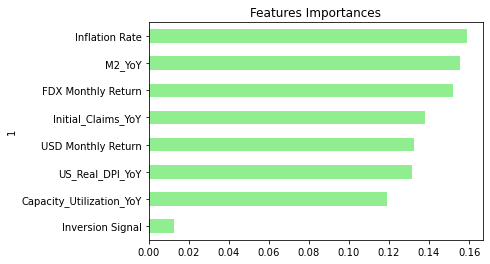

In [150]:
# Visualize the features by their importance to the model
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, new_df[x_var_list]), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [151]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.25      0.12      0.88      0.16      0.32      0.10        25
        1.0       0.74      0.88      0.12      0.80      0.32      0.11        72

avg / total       0.61      0.68      0.31      0.64      0.32      0.11        97



### Logistic Regression

In [152]:
from sklearn.linear_model import LogisticRegression
model_logreg = LogisticRegression(solver='lbfgs', random_state=1)
model_logreg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1)

In [153]:
# Display the confusion matrix

predictions_logreg = model_logreg.predict(X_test_scaled)
cm_3 = confusion_matrix(y_test, predictions_logreg)
cm_to_df(cm_3, "Logistic Regression Confusion Matrix")

Confusion Matrix - Logistic Regression Confusion Matrix


Predicted Negative  Predicted Positive
Negative                   0                  25
Positive                   4                  68

In [154]:
print("Test set accuracy: {:.2f}".format(model_logreg.score(X_test_scaled, y_test)))

Test set accuracy: 0.70


In [155]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, predictions_logreg))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.00      0.00      0.94      0.00      0.00      0.00        25
        1.0       0.73      0.94      0.00      0.82      0.00      0.00        72

avg / total       0.54      0.70      0.24      0.61      0.00      0.00        97



### Smote Oversampling

In [156]:
# Resample the training data with SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE


X_resampled_2, y_resampled_2 = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(
    X_train_scaled, y_train
)

Counter(y_resampled_2)

Counter({1.0: 142, 0.0: 142})

In [157]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model_smote = LogisticRegression(solver='lbfgs', random_state=1)
model_smote.fit(X_resampled_2, y_resampled_2)

LogisticRegression(random_state=1)

In [158]:
# Display the confusion matrix

predictions_smote = model_smote.predict(X_test_scaled)
cm_3 = confusion_matrix(y_test, predictions_smote)
cm_to_df(cm_3, "SMOTE Algorithm Confusion Matrix")

Confusion Matrix - SMOTE Algorithm Confusion Matrix


Predicted Negative  Predicted Positive
Negative                  13                  12
Positive                  37                  35

In [159]:
print("Test set accuracy: {:.2f}".format(model_smote.score(X_test_scaled, y_test)))

Test set accuracy: 0.49


### Gradient Boosting

In [173]:
# Choose a learning rate and create classifier
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.63,
                                        max_features=5,
                                        random_state=0)

# Fit the model
classifier.fit(X_train_scaled, y_train.ravel())

GradientBoostingClassifier(learning_rate=0.63, max_features=5, n_estimators=20,
                           random_state=0)

In [174]:
# Make Prediction
predictions_gradient = classifier.predict(X_test_scaled)
cm_3 = confusion_matrix(y_test, predictions_gradient)
cm_to_df(cm_3, "Gradient Boosting Algorithm Confusion Matrix")

Confusion Matrix - Gradient Boosting Algorithm Confusion Matrix


Predicted Negative  Predicted Positive
Negative                   6                  19
Positive                  10                  62

In [175]:
print("Test set accuracy: {:.2f}".format(classifier.score(X_test_scaled, y_test)))

Test set accuracy: 0.70


### Algo Trading Strategy

In [176]:
Results["Percentage Return"] = master_df['Monthly Return']/100
Results["Logistic Regression Predicted Value"] = predictions_logreg
Results["SMOTE Predicted Value"] = predictions_smote
Results["Gradient Boost Predicted Value"] = predictions_gradient

Results.head(20)

Monthly Return  Predicted Value  Percentage Return  \
Date                                                             
2012-07-31             1.0              1.0           0.011829   
2012-08-31             1.0              1.0           0.025052   
2012-09-30             1.0              1.0           0.025351   
2012-10-31             0.0              1.0          -0.018198   
2012-11-30             1.0              1.0           0.005660   
2012-12-31             1.0             -1.0           0.008934   
2013-01-31             1.0             -1.0           0.051190   
2013-02-28             1.0              1.0           0.012759   
2013-03-31             1.0              1.0           0.037972   
2013-04-30             1.0              1.0           0.019212   
2013-05-31             1.0              1.0           0.023610   
2013-06-30             0.0              1.0          -0.013345   
2013-07-31             1.0              1.0           0.051677   
2013-08-31             0.0              1.0          -0.029993   
2013-09-30             1.0              1.0           0.031647   
2013-10-31             1.0              1.0           0.046307   
2013-11-30             1.0              1.0           0.029637   
2013-12-31             1.0              1.0           0.025927   
2014-01-31             0.0              1.0          -0.035248   
2014-02-28             1.0              1.0           0.045516   

            Logistic Regression Predicted Value  SMOTE Predicted Value  \
Date                                                                     
2012-07-31                                  1.0                    0.0   
2012-08-31                                  1.0                    0.0   
2012-09-30                                  1.0                    1.0   
2012-10-31                                  1.0                    1.0   
2012-11-30                                  1.0                    0.0   
2012-12-31                                  1.0                    0.0   
2013-01-31                                  1.0                    0.0   
2013-02-28                                  1.0                    0.0   
2013-03-31                                  1.0                    0.0   
2013-04-30                                  1.0                    0.0   
2013-05-31                                  1.0                    0.0   
2013-06-30                                  1.0                    0.0   
2013-07-31                                  1.0                    0.0   
2013-08-31                                  1.0                    0.0   
2013-09-30                                  1.0                    0.0   
2013-10-31                                  1.0                    0.0   
2013-11-30                                  1.0                    0.0   
2013-12-31                                  1.0                    0.0   
2014-01-31                                  1.0                    0.0   
2014-02-28                                  1.0                    0.0   

            Gradient Boost Predicted Value  
Date                                        
2012-07-31                             1.0  
2012-08-31                             0.0  
2012-09-30                             1.0  
2012-10-31                             0.0  
2012-11-30                             1.0  
2012-12-31                             1.0  
2013-01-31                             0.0  
2013-02-28                             1.0  
2013-03-31                             1.0  
2013-04-30                             1.0  
2013-05-31                             1.0  
2013-06-30                             1.0  
2013-07-31                             1.0  
2013-08-31                             1.0  
2013-09-30                             0.0  
2013-10-31                             1.0  
2013-11-30                             1.0  
2013-12-31                             1.0  
2014-01-31                    

In [182]:
# Replace predicted values 0 to -1 to account for shorting
Results['Predicted Value'].replace(0, -1, inplace=True)
Results["Predicted Value"].value_counts()

Results['Logistic Regression Predicted Value'].replace(0, -1, inplace=True)
Results["Logistic Regression Predicted Value"].value_counts()

Results['SMOTE Predicted Value'].replace(0, -1, inplace=True)
Results["SMOTE Predicted Value"].value_counts()

Results['Gradient Boost Predicted Value'].replace(0, -1, inplace=True)
Results["Gradient Boost Predicted Value"].value_counts()

Results.tail(12)

Monthly Return  Predicted Value  Percentage Return  \
Date                                                             
2019-08-31             0.0              1.0          -0.016744   
2019-09-30             1.0              1.0           0.019458   
2019-10-31             1.0              1.0           0.022105   
2019-11-30             1.0             -1.0           0.036198   
2019-12-31             1.0             -1.0           0.029055   
2020-01-31             0.0             -1.0          -0.000404   
2020-02-29             0.0             -1.0          -0.079166   
2020-03-31             0.0             -1.0          -0.124871   
2020-04-30             1.0             -1.0           0.126984   
2020-05-31             1.0             -1.0           0.047645   
2020-06-30             1.0             -1.0           0.017734   
2020-07-31             1.0             -1.0           0.058892   

            Logistic Regression Predicted Value  SMOTE Predicted Value  \
Date                                                                     
2019-08-31                                  1.0                   -1.0   
2019-09-30                                  1.0                   -1.0   
2019-10-31                                  1.0                   -1.0   
2019-11-30                                  1.0                    1.0   
2019-12-31                                  1.0                   -1.0   
2020-01-31                                  1.0                   -1.0   
2020-02-29                                  1.0                   -1.0   
2020-03-31                                  1.0                   -1.0   
2020-04-30                                 -1.0                   -1.0   
2020-05-31                                 -1.0                    1.0   
2020-06-30                                 -1.0                   -1.0   
2020-07-31                                 -1.0                   -1.0   

            Gradient Boost Predicted Value  
Date                                        
2019-08-31                             1.0  
2019-09-30                             1.0  
2019-10-31                             1.0  
2019-11-30                             1.0  
2019-12-31                             1.0  
2020-01-31                             1.0  
2020-02-29                             1.0  
2020-03-31                            -1.0  
2020-04-30                            -1.0  
2020-05-31                             1.0  
2020-06-30                             1.0  
2020-07-31                             1.0

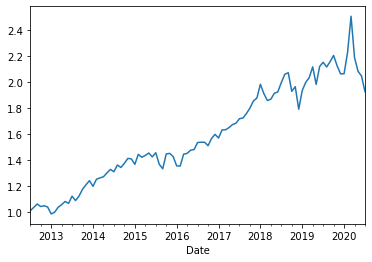

In [162]:
# Calculate cumulative return of model and plot the result
(1 + (Results['Percentage Return'] * Results['Predicted Value'])).cumprod().plot()

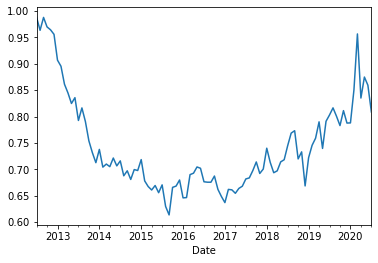

In [163]:
# Calculate cumulative return of SMOTE model and plot the result
(1 + (Results['Percentage Return'] * Results['SMOTE Predicted Value'])).cumprod().plot()

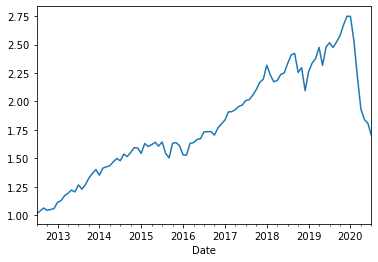

In [164]:
# Calculate cumulative return of Logistic Regression model and plot the result
(1 + (Results['Percentage Return'] * Results['Logistic Regression Predicted Value'])).cumprod().plot()

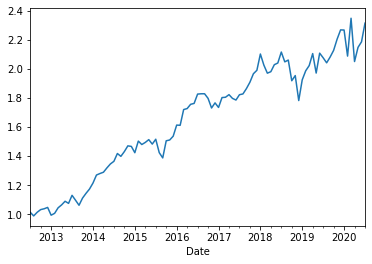

In [178]:
# Calculate cumulative return of Gradient Boosting model and plot the result
(1 + (Results['Percentage Return'] * Results['Gradient Boost Predicted Value'])).cumprod().plot()

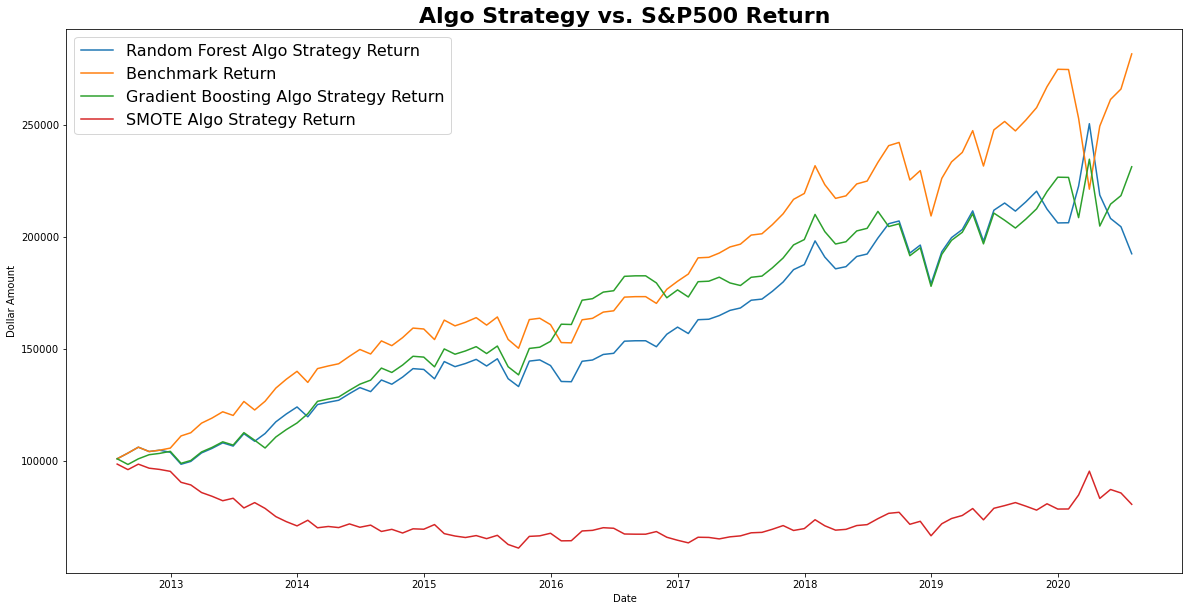

In [180]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_RF_capital = initial_capital * (1 + (Results['Percentage Return'] * Results['Predicted Value'])).cumprod()
benchmark_return = initial_capital * (1+(Results['Percentage Return'])).cumprod()
cumulative_gradient_return = initial_capital * (1 + (Results['Percentage Return'] * Results['Gradient Boost Predicted Value'])).cumprod()
cumulative_SMOTE_return = initial_capital * (1 + (Results['Percentage Return'] * Results['SMOTE Predicted Value'])).cumprod()
cumulative_Logreg_return = initial_capital * (1 + (Results['Percentage Return'] * Results['Logistic Regression Predicted Value'])).cumprod()


plt.subplots(figsize=(20,10))
plt.plot(cumulative_RF_capital)
plt.plot(benchmark_return)
plt.plot(cumulative_gradient_return)
plt.plot(cumulative_SMOTE_return)
#plt.plot(cumulative_Logreg_return)

plt.legend(["Random Forest Algo Strategy Return", 
            "Benchmark Return",
            "Gradient Boosting Algo Strategy Return", 
            "SMOTE Algo Strategy Return",
            #"Logistic Regression Algo Strategy Return"
           ], 
           prop={'size': 16})
plt.xlabel("Date")
plt.ylabel("Dollar Amount")
plt.title(f"Algo Strategy vs. S&P500 Return", fontdict={'fontweight':'bold', 'fontsize':'22'})
plt.show()